# Time-Series Forecasting (Next-Window Spike Prediction)

This notebook implements the required **time-series prediction** task by forecasting the **next-window maximum packet rate** (`max(flow_pkts_per_sec)`), using **non-overlapping event buckets** and **walk-forward evaluation**.

This formulation avoids trivial persistence effects and is appropriate for production-style validation.


In [1]:
import os, sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from dataclasses import dataclass
from typing import Dict, Tuple, List

from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor, HistGradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

sys.path.append("../src")
from common_utils import print_section, load_csv, save_json, ensure_dir

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)


In [2]:
@dataclass
class CFG:
    data_path: str = "../data/processed/rt_iot2022_dos_syn_model_ready.csv"
    base_col: str = "flow_pkts_per_sec"

    window_size: int = 1000
    stride: int = 1000            # non-overlapping
    target_mode: str = "next_max" # or "next_mean"

    n_folds: int = 3
    final_train_frac: float = 0.8

    out_dir: str = "../artifacts_timeseries"

cfg = CFG()


In [3]:
df_ts = load_csv(cfg.data_path)
print_section("Loaded Dataset")
print("Shape:", df_ts.shape)
print("Columns contains base_col?", cfg.base_col in df_ts.columns)



Loaded Dataset
Shape: (123117, 85)
Columns contains base_col? True


In [4]:
def rmse(y_true, y_pred) -> float:
    return float(np.sqrt(mean_squared_error(y_true, y_pred)))

def make_bucketed_ts_dataset(
    df: pd.DataFrame,
    base_col: str,
    window_size: int,
    stride: int,
    target_mode: str = "next_max"
) -> Tuple[pd.DataFrame, np.ndarray, np.ndarray]:
    s = df[base_col].astype(float).reset_index(drop=True)
    X_rows, y_rows, idx_rows = [], [], []

    n = len(s)
    starts = list(range(0, n - 2*window_size + 1, stride))

    for start in starts:
        past = s.iloc[start : start + window_size]
        fut  = s.iloc[start + window_size : start + 2*window_size]

        X_rows.append({
            "past_mean": float(past.mean()),
            "past_std":  float(past.std()),
            "past_max":  float(past.max()),
            "past_p95":  float(past.quantile(0.95)),
            "past_p99":  float(past.quantile(0.99)),
        })

        if target_mode == "next_max":
            y_rows.append(float(fut.max()))
        elif target_mode == "next_mean":
            y_rows.append(float(fut.mean()))
        else:
            raise ValueError("target_mode must be 'next_max' or 'next_mean'")

        idx_rows.append(start)

    X = pd.DataFrame(X_rows)
    y = np.array(y_rows, dtype=float)
    idx = np.array(idx_rows, dtype=int)
    return X, y, idx

Xb, yb, idxb = make_bucketed_ts_dataset(
    df_ts, base_col=cfg.base_col,
    window_size=cfg.window_size, stride=cfg.stride,
    target_mode=cfg.target_mode
)

print_section("Bucketed TS Dataset")
print("X:", Xb.shape, "y:", yb.shape)
print(pd.Series(yb).describe())



Bucketed TS Dataset
X: (122, 5) y: (122,)
count    122.000000
mean      12.828230
std        3.035361
min        0.000000
25%       13.457480
50%       13.457480
75%       14.556091
max       14.556091
dtype: float64


In [5]:
def evaluate_regression(y_true, y_pred) -> Dict[str, float]:
    return {
        "rmse": rmse(y_true, y_pred),
        "mae": float(mean_absolute_error(y_true, y_pred)),
        "r2": float(r2_score(y_true, y_pred))
    }

def walk_forward_splits(X: pd.DataFrame, y: np.ndarray, n_folds: int = 3):
    n = len(X)
    splits = []
    train_fracs = np.linspace(0.6, 0.8, n_folds)
    test_frac = 0.1

    for tf in train_fracs:
        train_end = int(n * tf)
        test_end = min(n, train_end + int(n * test_frac))
        Xtr, ytr = X.iloc[:train_end], y[:train_end]
        Xte, yte = X.iloc[train_end:test_end], y[train_end:test_end]
        splits.append((Xtr, ytr, Xte, yte))
    return splits

def baseline_last_value(y_train: np.ndarray, n_test: int) -> np.ndarray:
    return np.full(n_test, float(y_train[-1]), dtype=float)

models = {
    "Ridge(alpha=1.0)": Ridge(alpha=1.0),
    "RF(n=300)": RandomForestRegressor(n_estimators=300, random_state=RANDOM_SEED),
    "HGB": HistGradientBoostingRegressor(random_state=RANDOM_SEED),
}

splits = walk_forward_splits(Xb, yb, n_folds=cfg.n_folds)

results = []
for fold_i, (Xtr, ytr, Xte, yte) in enumerate(splits, start=1):
    print_section(f"Walk-forward Fold {fold_i}")

    base_pred = baseline_last_value(ytr, len(yte))
    base_m = evaluate_regression(yte, base_pred)
    print("Baseline(last value):", base_m)

    for name, m in models.items():
        m.fit(Xtr, ytr)
        pred = m.predict(Xte)
        met = evaluate_regression(yte, pred)
        print(f"{name}:", met)
        results.append({"fold": fold_i, "model": name, **met})

results_df = pd.DataFrame(results)
print_section("Summary Across Folds")
display(results_df)



Walk-forward Fold 1
Baseline(last value): {'rmse': 0.584614755559564, 'mae': 0.33241505905881724, 'r2': -0.4777859390258501}
Ridge(alpha=1.0): {'rmse': 0.34286802652484105, 'mae': 0.24742192675146932, 'r2': 0.4916931526047257}
RF(n=300): {'rmse': 0.35531290840813257, 'mae': 0.27412762434104776, 'r2': 0.45412405625456265}
HGB: {'rmse': 0.34719005318554347, 'mae': 0.3103681063127966, 'r2': 0.4787974481471913}

Walk-forward Fold 2
Baseline(last value): {'rmse': 0.7768355248628231, 'mae': 0.5493056674971131, 'r2': -0.9999999999999998}
Ridge(alpha=1.0): {'rmse': 0.49843123253556754, 'mae': 0.3475500657026413, 'r2': 0.1766540824838687}
RF(n=300): {'rmse': 0.4586203033859154, 'mae': 0.3305461042534219, 'r2': 0.3029267858881217}
HGB: {'rmse': 0.5169337941810683, 'mae': 0.4323085001623734, 'r2': 0.11439167628049507}

Walk-forward Fold 3
Baseline(last value): {'rmse': 0.8970123987912303, 'mae': 0.7324075566628174, 'r2': -2.0}
Ridge(alpha=1.0): {'rmse': 0.5725834636506044, 'mae': 0.4001468679159

,fold,model,rmse,mae,r2
0,1,Ridge(alpha=1.0),0.342868,0.247422,0.491693
1,1,RF(n=300),0.355313,0.274128,0.454124
2,1,HGB,0.347190,0.310368,0.478797
3,2,Ridge(alpha=1.0),0.498431,0.347550,0.176654
4,2,RF(n=300),0.458620,0.330546,0.302927
5,2,HGB,0.516934,0.432309,0.114392
6,3,Ridge(alpha=1.0),0.572583,0.400147,-0.222368
7,3,RF(n=300),0.523093,0.404285,-0.020191
8,3,HGB,0.576580,0.465731,-0.239493


In [6]:
# Final holdout evaluation (train first final_train_frac, test remainder)
def final_holdout_split(X: pd.DataFrame, y: np.ndarray, train_frac: float = 0.8):
    n = len(X)
    split = int(n * train_frac)
    return X.iloc[:split], y[:split], X.iloc[split:], y[split:]

Xtr_f, ytr_f, Xte_f, yte_f = final_holdout_split(Xb, yb, train_frac=cfg.final_train_frac)

final_models = {
    "Ridge(alpha=1.0)": Ridge(alpha=1.0),
    "RF(n=300)": RandomForestRegressor(n_estimators=300, random_state=RANDOM_SEED),
    "HGB": HistGradientBoostingRegressor(random_state=RANDOM_SEED),
}

print_section("Final Holdout Comparison")
final_rows = []
for name, m in final_models.items():
    m.fit(Xtr_f, ytr_f)
    pred = m.predict(Xte_f)
    met = evaluate_regression(yte_f, pred)
    print(name, met)
    final_rows.append({"model": name, **met})

final_tbl = pd.DataFrame(final_rows).sort_values("rmse")
display(final_tbl)

best_name = final_tbl.iloc[0]["model"]
print("Selected final TS model:", best_name)



Final Holdout Comparison
Ridge(alpha=1.0) {'rmse': 4.333472481434627, 'mae': 2.093281329799942, 'r2': -0.025093845910969748}
RF(n=300) {'rmse': 4.3743248444169796, 'mae': 2.2410232250608413, 'r2': -0.044512406502812185}
HGB {'rmse': 3.9962491434459717, 'mae': 2.2764459523485634, 'r2': 0.12824057270460487}


,model,rmse,mae,r2
2,HGB,3.996249,2.276446,0.128241
0,Ridge(alpha=1.0),4.333472,2.093281,-0.025094
1,RF(n=300),4.374325,2.241023,-0.044512


Selected final TS model: HGB


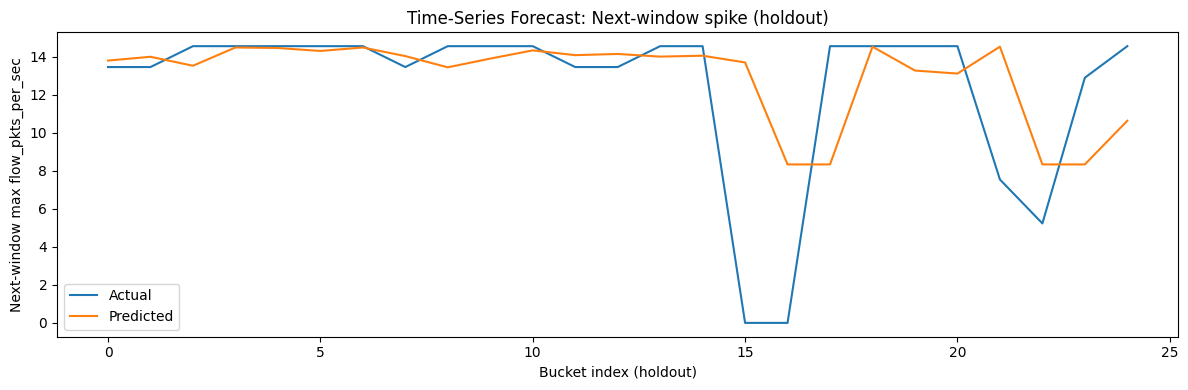

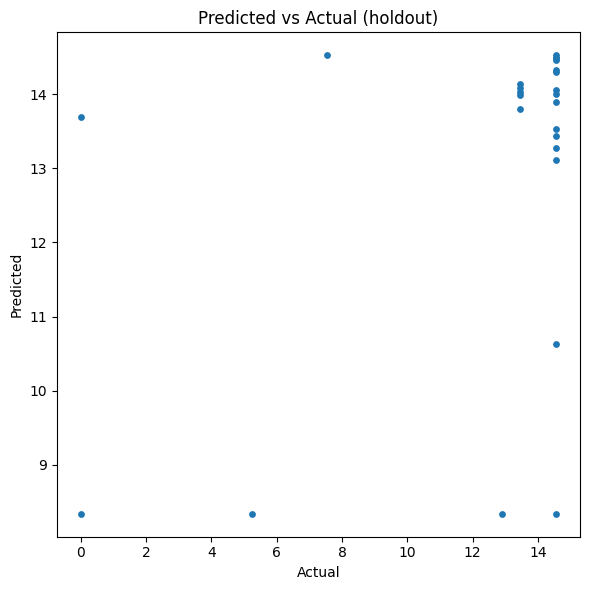

In [7]:
# Plot best model predictions (final holdout)
best_model = final_models[best_name]
best_model.fit(Xtr_f, ytr_f)
pred_best = best_model.predict(Xte_f)

plt.figure(figsize=(12,4))
plt.plot(yte_f, label="Actual")
plt.plot(pred_best, label="Predicted")
plt.title("Time-Series Forecast: Next-window spike (holdout)")
plt.xlabel("Bucket index (holdout)")
plt.ylabel("Next-window max flow_pkts_per_sec")
plt.legend()
plt.tight_layout()
plt.show()

plt.figure(figsize=(6,6))
plt.scatter(yte_f, pred_best, s=15)
plt.title("Predicted vs Actual (holdout)")
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.tight_layout()
plt.show()


In [8]:
# Save results
ensure_dir(cfg.out_dir)
payload = {
    "config": cfg.__dict__,
    "walk_forward_results": results,
    "final_holdout_results": final_rows,
    "selected_final_model": best_name,
}
save_json(os.path.join(cfg.out_dir, "metrics.json"), payload)

print_section("Saved")
print(os.path.join(cfg.out_dir, "metrics.json"))



Saved
../artifacts_timeseries\metrics.json
